In [1]:
import pandas as pd
import torch
from torch import cuda
import seqeval
from seqeval.metrics import classification_report, accuracy_score
from transformers import AutoTokenizer, AutoModelForTokenClassification, AdamW
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
# 60 train, 20 dev, 20 test
train_df = pd.read_csv('data/processed/phee/ace/train_w_test_tag_mapped.csv')
dev_df = pd.read_csv('data/processed/phee/ace/dev_w_test_tag_mapped.csv')
test_df = pd.read_csv('data/processed/phee/ace/test_w_test_tag_mapped.csv')

In [5]:
train_df = train_df[['Sentence', 'Med_Tag']]
train_df.rename(columns={"Sentence": "sentence", "Med_Tag": "tag"}, inplace=True)
train_df

,sentence,tag
0,objective : to test the hypothesis that tumor ...,O O O O O O O O O O O O O O O O O O O O O O O ...
1,an evaluation of ovarian structure and functio...,O I-Test I-Test O O O O O O O O I-Background I...
2,phenobarbital hepatotoxicity in an 8 - month -...,I-Treatment I-Problem O I-Background I-Backgro...
3,the authors report a case of balint syndrome w...,O O O O O O I-Problem I-Problem I-Problem I-Pr...
4,"according to the naranjo probability scale , f...",O O O O I-Test I-Test O I-Treatment O O O O O ...
...,...,...
3001,l - t4 stimulated lymphocyte transformation in...,I-Treatment I-Treatment I-Treatment O I-Proble...
3002,a 53 - year - old man developed lower leg edem...,I-Background I-Background I-Background I-Backg...
3003,a mentally retarded 23 - year - old woman with...,I-Background I-Problem I-Problem I-Background ...
3004,"after 5 days of treatment with il - 2 , the pa...",I-Other I-Treatment I-Treatment I-Treatment I-...


In [6]:
dev_df = dev_df[['Sentence', 'Med_Tag']]
dev_df.rename(columns={"Sentence": "sentence", "Med_Tag": "tag"}, inplace=True)
dev_df

,sentence,tag
0,physicians should be aware that plp can occur ...,O O O O O I-Problem O O O O O I-Treatment O
1,heparin - dependent antibodies and thrombosis ...,O O O O O O O I-Treatment O O I-Problem O
2,treatment of lithium tremor with metoprolol .,O O I-Treatment I-Problem O I-Treatment O
3,"a 54 - year - old man , treated with amiodaron...",I-Background I-Background I-Background I-Backg...
4,gynaecomastia is a rarely reported adverse dru...,I-Problem O O O O O O O O O I-Treatment I-Trea...
...,...,...
998,successful challenge with clozapine in a histo...,O O O I-Treatment O O O O I-Problem O
999,case summary : a 57 - year - old female with c...,O O O I-Background I-Background I-Background I...
1000,acute intravascular hemolysis developed when a...,I-Problem I-Problem I-Problem O O I-Background...
1001,intravitreal triamcinolone may have had an inf...,I-Treatment I-Treatment O O O O O O O I-Proble...


In [7]:
label2id = {k: v for v, k in enumerate(train_df['tag'].str.split().explode().unique())}
id2label = {v: k for v, k in enumerate(train_df['tag'].str.split().explode().unique())}
label2id

{'O': 0,
 'I-Treatment': 1,
 'I-Test': 2,
 'I-Problem': 3,
 'I-Background': 4,
 'I-Other': 5}

In [8]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 1
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10

In [9]:
tokenizer = AutoTokenizer.from_pretrained("samrawal/bert-base-uncased_clinical-ner")

In [14]:
for i in tokenizer("He got Ferium").input_ids:
    print(tokenizer.decode(i))

[CLS]
he
got
fe
##rium
[SEP]


In [17]:
# padding='max_length', truncation=True => padding to max model input length
def process_sentence(sentence, tag):
    inputs = [tokenizer(sentence, add_special_tokens=True, padding='max_length', max_length=MAX_LEN, return_tensors="pt", return_attention_mask=True)]
    token_labels = []
    # tag = -100 + tag + -100  # Using 'O' as dummy labels for [CLS] and [SEP]
    for word, label in zip(sentence.split(), tag.split()):
        word_tokens = tokenizer.tokenize(word)
        # Assign the same label to all subwords of a word
        token_labels.extend([label2id[label]] * len(word_tokens))
    token_labels = [-100] + token_labels +  [-100] 
    # Pad labels to match the max length
    padding_length = MAX_LEN - len(token_labels)  # Adjusted for max length
    token_labels += [-100] * padding_length  # Using -100 label for padding

    # Convert labels to PyTorch tensor
    token_labels = torch.tensor([token_labels])

    return inputs, token_labels

In [18]:
def tokenize(df):   
    input_list = []
    label_list = []
    for sentence, tag  in zip(df['sentence'], df['tag']):
        inputs, labels = process_sentence(sentence, tag)  
        input_list.append(inputs)
        label_list.append(labels)
    return input_list, label_list


In [19]:
def plot_graph(list, name):

    # Plotting the line graph
    plt.plot(list, marker='o', linestyle='-', color='g', label='Value')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{name} Loss')

    # Display the legend
    plt.legend()

    # save plot to file
    plt.savefig(f'analysis/graphs/{name}.png')
    

In [20]:
def evaluate(df, model, type):
    all_inputs, all_labels = tokenize(df)
    loss, accuracy = 0, 0
    nb_steps = 0
    predictions = []
    references = []
    for idx, (inputs, labels) in enumerate(zip(all_inputs, all_labels)):  # Replace with actual batch generation
        ids = inputs[0]['input_ids'].to(device)
        mask = inputs[0]['attention_mask'].to(device)
        labels = labels.to(device)
        with torch.no_grad():
            outputs = model(input_ids=ids, attention_mask=mask, labels=labels)

        loss, logits = outputs.loss, outputs.logits
        preds = torch.argmax(logits, dim=2)
        
        ref = [id2label[l.item()] for label in labels for l in label if l != -100]
        references.append(ref)
        predictions.append([id2label[p.item()] for pred in preds for p in pred[1:len(ref)]])

        loss += loss.item()

        nb_steps += 1
        # nb_tr_examples += targets.size(0)

    epoch_loss = loss / nb_steps
    
    accuracy = accuracy_score(y_pred=predictions, y_true=references)
    print(f"{type} loss: {epoch_loss}")
    print(f"{type} accuracy: {accuracy}")
    
    return predictions, references, epoch_loss


In [33]:
def train(all_inputs, all_labels):
    model = AutoModelForTokenClassification.from_pretrained("samrawal/bert-base-uncased_clinical-ner", num_labels=len(id2label), id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)
    optimizer = AdamW(model.parameters(), lr=1e-5)  
    model.to(device)
    # Training loop
    model.train()  # Set the model to training mode
    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    for epoch in range(5):
        tr_loss, tr_accuracy = 0, 0
        nb_tr_steps = 0
        predictions = []
        references = []
        for idx, (inputs, labels) in enumerate(zip(all_inputs, all_labels)):  # Replace with actual batch generation
            ids = inputs[0]['input_ids'].to(device)
            mask = inputs[0]['attention_mask'].to(device)
            labels = labels.to(device)

            outputs = model(input_ids=ids, attention_mask=mask, labels=labels)

            loss, tr_logits = outputs.loss, outputs.logits
            preds = torch.argmax(tr_logits, dim=2)
            # print('preds: ', preds)
            # print('labels: ', labels)
            ref = [id2label[l.item()] for label in labels for l in label if l != -100]
            references.append(ref)
            predictions.append([id2label[p.item()] for pred in preds for p in pred[1:len(ref)+1]])
            
            
            # Convert predictions to numpy array
            # predictions = predictions.detach().cpu().numpy()

            # Optional: Print or evaluate predictions
            # print(f"Predictions in epoch {epoch + 1}:", preds)
            
            # print('labels', labels) 
            # for id in ids:
            #     print(tokenizer.decode(id))

            tr_loss += loss.item()

            nb_tr_steps += 1
            # nb_tr_examples += targets.size(0)
            
            if idx > 0 and (idx % 1000 == 0):
                loss_step = tr_loss/nb_tr_steps
                print(f"Training loss per 1000 training steps: {loss_step}")

            # # gradient clipping
            # torch.nn.utils.clip_grad_norm_(
            #     parameters=model.parameters(), max_norm=MAX_GRAD_NORM
            # )
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

        epoch_loss = tr_loss / nb_tr_steps
       
        tr_accuracy = accuracy_score(y_pred=predictions, y_true=references)
        print(f"Training loss epoch: {epoch_loss}")
        print(f"Training accuracy epoch: {tr_accuracy}")
        train_losses.append(epoch_loss)

        val_preds, val_labels, val_loss = evaluate(dev_df, model, 'Validation')
        val_losses.append(val_loss.item())

        if best_val_loss > val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'models/med_highlight_bert_model.pt')
            print('Saving model...')
        
            # save classification report
            report = classification_report(y_pred=predictions, y_true=references)
            with open(f'analysis/reports/clinical_bert_{type}_report.txt', 'w') as f:
                f.write(report)

    # Plotting both the training loss and the validation loss
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')

    # Adding a legend to distinguish the lines
    plt.legend()

    # save plot to file
    plt.savefig(f'analysis/graphs/train_val_losses.png')
    

Some weights of BertForTokenClassification were not initialized from the model checkpoint at samrawal/bert-base-uncased_clinical-ner and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training loss per 1000 training steps: 0.5222086195390184
Training loss per 1000 training steps: 0.4642930561904681
Training loss per 1000 training steps: 0.4332047715281614
Training loss epoch: 0.4327994906582082
Training accuracy epoch: 0.8303228206506014
Validation loss: 0.000940294936299324
Validation accuracy: 0.2966918627781008
Saving model...
Training loss per 1000 training steps: 0.3104672153111916
Training loss per 1000 training steps: 0.2981192571458233
Training loss per 1000 training steps: 0.282407908453378
Training loss epoch: 0.2821399690636018
Training accuracy epoch: 0.878931922456909
Validation loss: 0.0007503708475269377
Validation accuracy: 0.296630657649111
Saving model...
Training loss per 1000 training steps: 0.21708495190323374
Training loss per 1000 training steps: 0.2114496508863164
Training loss per 1000 training steps: 0.20093553426432814
Training loss epoch: 0.20082290578456638
Training accuracy epoch: 0.9108729797875419
Validation loss: 0.000651071488391608

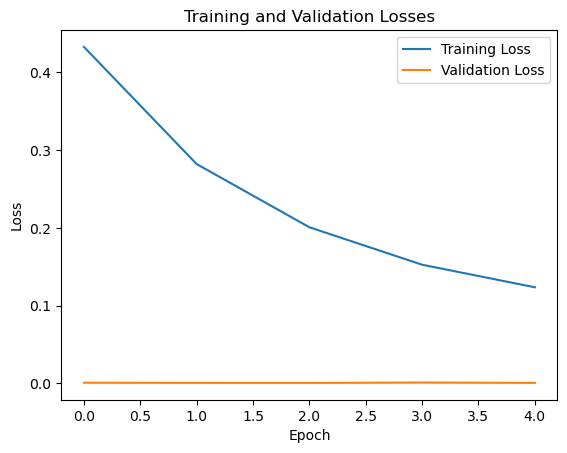

In [34]:
inputs, labels = tokenize(train_df)
train(inputs, labels)